#Preprocessing


In [3]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.0 MB 20 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.1-py2.py3-none-any.whl size=177068062 sha256=d4a699f80c7828ccdc38aa38f27ed84fccc27763f346053e5ab942d05579f987
  Stored in directory: /root/.cache/pip/wheels/a6/d9/ab/5442447c7e2ccf07f66aa8b79f3877ce5382f0b95e6c0c797b
Successfully built h2o


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,17 mins 36 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_ujghfo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


- Importing data

In [30]:
X_train = pd.read_csv('X_train.csv').drop(columns=['country'])
y_train = pd.read_csv('y_train.csv')

X_test = pd.read_csv('X_test.csv').drop(columns=['country'])
y_test = pd.read_csv('y_test.csv')
X_train.head()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,...,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developing,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
0,2014,61.0,0,6.06,177.638288,80.940461,3,6.8,0,93.0,...,5.137232e+06,0.8,0.7,0.945,17.7,0,0,0,1,0
1,2007,291.0,2,9.02,545.438957,75.000000,0,31.9,3,78.0,...,1.489193e+06,6.9,6.8,0.645,12.4,1,0,0,0,0
2,2008,162.0,0,8.92,754.959713,99.000000,0,42.4,0,99.0,...,1.275338e+07,3.8,3.9,0.000,15.4,1,1,0,0,0
3,2000,185.0,0,2.23,0.000000,87.000000,0,61.5,0,85.0,...,1.275338e+07,0.3,0.3,0.000,0.0,1,0,0,0,1
4,2001,142.0,17,4.22,302.535906,80.940461,0,46.1,22,9.0,...,2.626136e+07,1.4,1.4,0.677,13.4,1,1,0,0,0


## Remove linear correlated features


In [31]:
#Observing the statistical information of numerical columns in the data 
X_train.describe()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,...,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_Developing,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
count,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,...,2.049000e+03,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,2007.550024,163.784773,30.890190,4.629194,729.941698,80.825034,2488.181064,38.305969,43.047828,82.501734,...,1.232505e+07,4.819225,4.852054,0.627866,12.017971,0.822352,0.183992,0.252318,0.213763,0.059053
std,4.632549,122.143019,117.699358,3.926122,1951.746016,22.751766,11891.273028,19.935305,161.664646,23.207281,...,5.080317e+07,4.422701,4.521714,0.203551,3.260015,0.382309,0.387572,0.434449,0.410061,0.235782
min,2000.000000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.400000,0.000000,3.000000,...,3.400000e+01,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,74.000000,0.000000,1.110000,5.889526,80.940461,0.000000,19.300000,0.000000,78.000000,...,4.439580e+05,1.600000,1.500000,0.497000,10.200000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,144.000000,3.000000,4.200000,67.639253,87.000000,15.000000,43.000000,4.000000,93.000000,...,3.757452e+06,3.300000,3.300000,0.663000,12.200000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2012.000000,225.000000,21.000000,7.400000,434.798502,96.000000,343.000000,56.100000,27.000000,97.000000,...,1.275338e+07,7.100000,7.100000,0.773000,14.100000,1.000000,0.000000,1.000000,0.000000,0.000000
max,2015.000000,693.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,...,1.293859e+09,27.700000,28.600000,0.948000,20.500000,1.000000,1.000000,1.000000,1.000000,1.000000


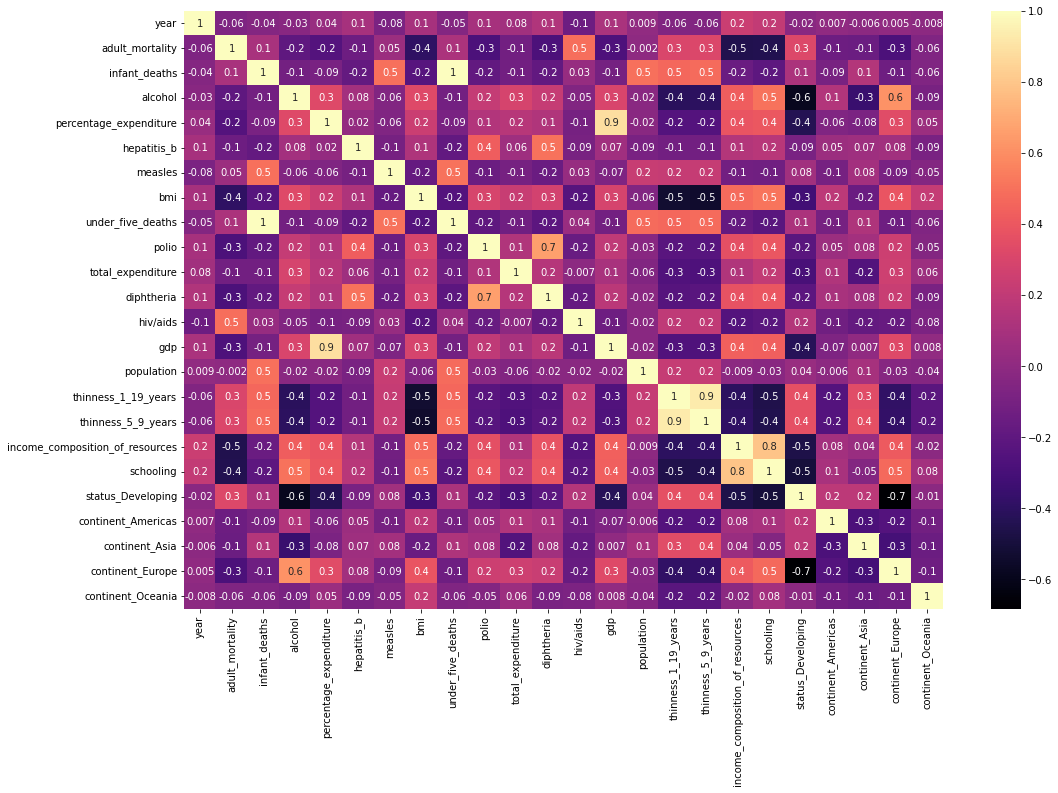

In [32]:
#Observing the correlation between each feature in the data
plt.figure(figsize=(17,11))
sns.heatmap(X_train.corr(), annot=True, cmap="magma", fmt='.1g')

- "under_five_deaths" and "infant_deaths" have correlation of 1.0
- "thinness_5_9_years" and "thinness_10_19_years" have correlation of 0.9
- "schooling" and "income_composition_of_resources" have correlation of 0.8
- "gdp" and "percentage_expenditure" have correlation of 0.9

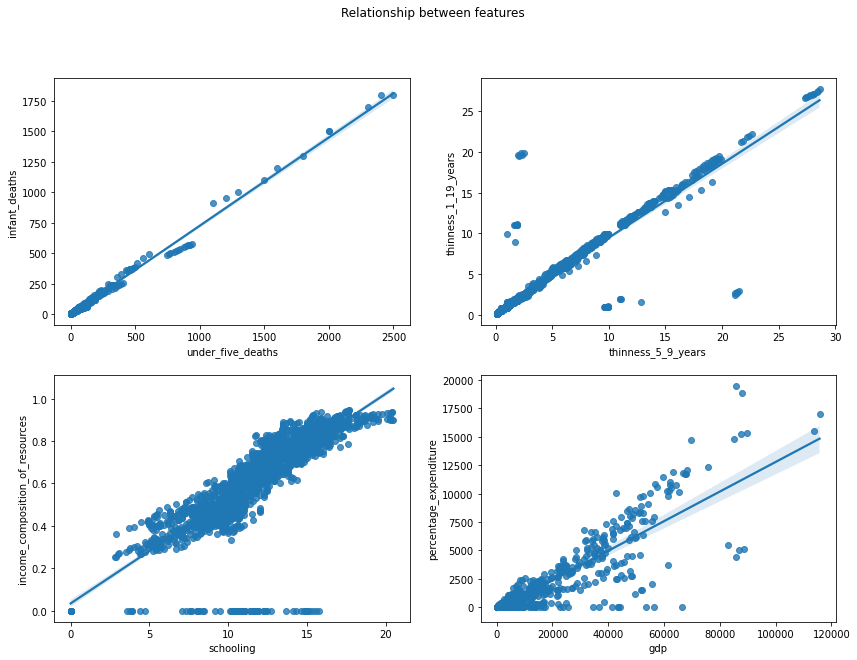

In [33]:
#Plot graph to see relationship between these features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Relationship between features')

sns.regplot(ax=axes[0,0], x=X_train['under_five_deaths'], y=X_train['infant_deaths'])

sns.regplot(ax=axes[0,1], x=X_train['thinness_5_9_years'], y=X_train['thinness_1_19_years'])

sns.regplot(ax=axes[1,0], x=X_train['schooling'], y=X_train['income_composition_of_resources'])

sns.regplot(ax=axes[1,1], x=X_train['gdp'], y=X_train['percentage_expenditure'])


In [34]:
#dropping 'under_five_deaths', 'thinness_5_9_years' columns
columns_drop = ['under_five_deaths', 'thinness_1_19_years', 'percentage_expenditure', 'schooling']

## Some helpful functions

- Functions to support feature selection
1.  feature_importance: visualize data frame for importances of every feature considered.
2.  pprint: calculate three model scores including r2 score (r2), root mean square error (rmse), mean absolute error (mae), show feature importances.
3.  compare_loss: Compare model scores, feature importances before and after dropping features.

In [35]:
#testing the loss in accuracy before and after removing features 

#making dataframe for feature importances
def feature_importance(model, x_train):
  importance = model.feature_importances_ 
  feature_importance = pd.DataFrame(importance, index=x_train.columns, columns=['Importances'])
  return feature_importance.sort_values(by=['Importances'], ascending=False)

def pprint(y_test, y_pred, feature_df=None, importance_show=False):
  r2 = r2_score(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'r2 score: {r2}')
  print(f'rmse: {rmse}')
  print(f'mae: {mae}')
  if importance_show:
    print('Importances of features:')
    print(feature_df)
  return r2, rmse, mae

#comparing different scores
def compare_loss(X_train, y_train, X_test, y_test, columns=[], estimator='RF', random_state=15):
  assert len(columns) != 0, "Please input the columns you want to drop before compare"
  X_train_dropped = X_train.drop(columns=columns, axis=1)
  X_test_dropped = X_test.drop(columns=columns, axis=1)
  if estimator == 'RF':
    #original data
    training = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=random_state)

    #dropping column
    training_dropped = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=random_state)

  if estimator == 'DT':
    #original data
    training = DecisionTreeRegressor(random_state=random_state)
    
    #dropping column
    training_dropped = DecisionTreeRegressor(random_state=random_state)
  
  training.fit(X_train, y_train)
  feature_importance_df = feature_importance(training, X_train)
  pred = training.predict(X_test)
  
  #compute score for original data
  print('Original:')
  _r2, _rmse, _mae = pprint(y_test, pred, feature_importance_df, importance_show=True)
  
  print('<------------------------------------------------------------------------------------------------------------>')
  
  training_dropped.fit(X_train_dropped, y_train)
  feature_importance_df_dropped = feature_importance(training_dropped, X_train_dropped)
  pred = training_dropped.predict(X_test_dropped)
  
  #compute score for dropped data
  print('Dropped:')
  _r2, _rmse, _mae =pprint(y_test, pred, feature_importance_df_dropped, importance_show=True)

- Functions to support detecting anomaly data points
1.  num_anomaly: count number of anomaly data points depending on threshold (> 0.5 and < 1).
2.  evaluate: check improvement in test data (split from original train data).

In [36]:
#counting number of anomaly data points
def num_anomaly(dataframe, anomaly_score, threshold):
  print(f'Number of anomaly data points with threshold {threshold}: {len(dataframe[anomaly_score > threshold])}')

#evaluating score 
def evaluate(X_train_h2o, y_train_h2o, X_test, y_test, 
             estimator, anomaly_score, columns_drop, threshold=0.6, random_state=15, 
             n_estimators=100, max_features='sqrt'):
  num_anomaly(dataframe=X_train_h2o,anomaly_score=anomaly_score, threshold=threshold)

  if estimator == 'DT':
    Life_Tree = DecisionTreeRegressor(random_state=random_state)
  if estimator == 'RF':
    Life_Tree = DecisionTreeRegressor(n_estimators=n_estimators, max_features=max_features, random_state=random_state)

  Life_Tree.fit(X_train_h2o[anomaly_score <= threshold].as_data_frame(), y_train_h2o[anomaly_score <= threshold].as_data_frame())
  pred = Life_Tree.predict(X_test.drop(columns=columns_drop))
  r2, rmse, mae = pprint(y_test, pred)

  return r2, rmse, mae


# Decision Tree

## Selecting features

In [37]:
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop, estimator='DT')

Original:
r2 score: 0.9137366111431913
rmse: 8.056177474402732
mae: 1.6673492605233224
Importances of features:
                                 Importances
hiv/aids                            0.589842
income_composition_of_resources     0.160398
adult_mortality                     0.113691
continent_Americas                  0.048911
year                                0.013838
alcohol                             0.009484
thinness_5_9_years                  0.009357
under_five_deaths                   0.009103
thinness_1_19_years                 0.006701
schooling                           0.005195
total_expenditure                   0.004973
infant_deaths                       0.004782
percentage_expenditure              0.004773
bmi                                 0.004501
population                          0.003663
polio                               0.003083
gdp                                 0.002708
diphtheria                          0.002152
hepatitis_b                      

- Dropping features that have importance percentage < 1%

In [38]:
columns_drop_dt = columns_drop + ['alcohol', 'infant_deaths', 'polio', 'diphtheria', 'gdp', 'bmi', 'continent_Oceania', 
                                  'status_Developing', 'continent_Asia', 'continent_Europe',  'year', 'measles'] 
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop_dt, estimator='DT')

Original:
r2 score: 0.9137366111431913
rmse: 8.056177474402732
mae: 1.6673492605233224
Importances of features:
                                 Importances
hiv/aids                            0.589842
income_composition_of_resources     0.160398
adult_mortality                     0.113691
continent_Americas                  0.048911
year                                0.013838
alcohol                             0.009484
thinness_5_9_years                  0.009357
under_five_deaths                   0.009103
thinness_1_19_years                 0.006701
schooling                           0.005195
total_expenditure                   0.004973
infant_deaths                       0.004782
percentage_expenditure              0.004773
bmi                                 0.004501
population                          0.003663
polio                               0.003083
gdp                                 0.002708
diphtheria                          0.002152
hepatitis_b                      

[Text(0.5, 0, 'adult_mortality'),
 Text(1.5, 0, 'hepatitis_b'),
 Text(2.5, 0, 'total_expenditure'),
 Text(3.5, 0, 'hiv/aids'),
 Text(4.5, 0, 'population'),
 Text(5.5, 0, 'thinness_5_9_years'),
 Text(6.5, 0, 'income_composition_of_resources'),
 Text(7.5, 0, 'continent_Americas')]

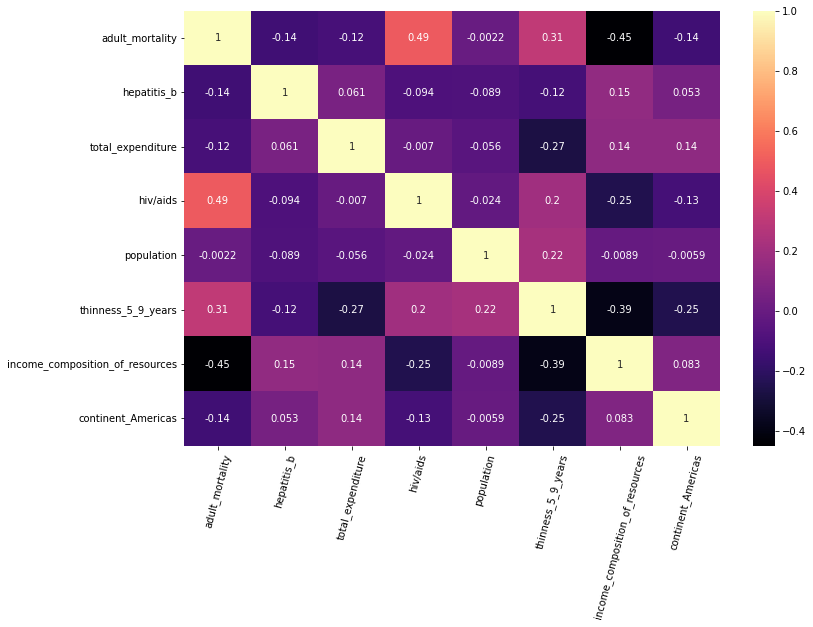

In [39]:
plt.figure(figsize=(12,8))
g = sns.heatmap(X_train.drop(columns=columns_drop_dt).corr(), cmap='magma', annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

## Outlier detecting

In [40]:
# Define an Extended Isolation forest model
X_train_dt = X_train.drop(columns=columns_drop_dt)
df_X = h2o.H2OFrame(X_train_dt)
df_y = h2o.H2OFrame(y_train)
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = df_X.dim[1] - 1,
                                          seed = 15
                                          )

# Train Extended Isolation Forest
eif.train(x = df_X.columns, 
          training_frame = df_X)

# Calculate score
eif_result = eif.predict(df_X)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [43]:
r2 = -1
for thres in np.arange(0.5, 1.1, 0.1):
  r2_pred, rmse_pred, mae_pred = evaluate(df_X, df_y, X_test, y_test, estimator='DT', anomaly_score=anomaly_score, columns_drop=columns_drop_dt, threshold=thres)
  if r2_pred > r2:
    r2 = r2_pred
    threshold = thres 

Number of anomaly data points with threshold 0.5: 230
r2 score: 0.8961435273862428
rmse: 9.69920364050057
mae: 1.8418657565415244
Number of anomaly data points with threshold 0.6: 110
r2 score: 0.8976612478895444
rmse: 9.5574630261661
mae: 1.7389078498293518
Number of anomaly data points with threshold 0.7: 36
r2 score: 0.8950259763871827
rmse: 9.803572241183163
mae: 1.8127417519908988
Number of anomaly data points with threshold 0.7999999999999999: 13
r2 score: 0.9155748327014882
rmse: 7.884505119453925
mae: 1.635267349260523
Number of anomaly data points with threshold 0.8999999999999999: 0
r2 score: 0.9152443426360369
rmse: 7.915369738339022
mae: 1.605346985210466
Number of anomaly data points with threshold 0.9999999999999999: 0
r2 score: 0.9152443426360369
rmse: 7.915369738339022
mae: 1.605346985210466
Number of anomaly data points with threshold 1.0999999999999999: 0
r2 score: 0.9152443426360369
rmse: 7.915369738339022
mae: 1.605346985210466


In [47]:
X_train_dt_cleaned = df_X[anomaly_score <= threshold].as_data_frame()
y_train_dt_cleaned = df_y[anomaly_score <= threshold].as_data_frame()

print(X_train_dt_cleaned.shape[0])
print(y_train_dt_cleaned.shape[0])

2036
2036


## Hyperparameter tunning

In [52]:
cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
params = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
          'random_state':np.arange(15)}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params, scoring='r2', cv=cv_sets, verbose= 3, n_jobs=-1)
grid_search.fit(X_train_dt_cleaned, y_train_dt_cleaned)
grid_search = grid_search.best_estimator_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


In [53]:
grid_search.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 5,
 'splitter': 'best'}

## Final training model and testing

In [55]:
Life_Tree = DecisionTreeRegressor(max_depth=10, random_state=5)
Life_Tree.fit(X_train_dt_cleaned, y_train_dt_cleaned)

print("Train score:")
pred = Life_Tree.predict(X_train_dt_cleaned)
pprint(y_test=y_train_dt_cleaned, y_pred=pred)
print('<-------------------------------------------------------------------------------------------------->')
print("Test score:")
pred = Life_Tree.predict(X_test.drop(columns=columns_drop_dt))
pprint(y_test=y_test, y_pred=pred)

Train score:
r2 score: 0.9804076591787417
rmse: 1.7608621440308199
mae: 0.795261506556752
<-------------------------------------------------------------------------------------------------->
Test score:
r2 score: 0.917255011894808
rmse: 7.727592413501099
mae: 1.7314684339126976


(0.917255011894808, 7.727592413501099, 1.7314684339126976)

# Random Forest

- Dropping continent features

In [ ]:
['population', 'year', 'hepatitis_b', 'measles', 'total_expenditure']

In [11]:
columns_drop += ['continent_Europe', 'continent_Asia', 'continent_Americas', 'continent_Oceania']
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop, estimator='DT')

Original:
r2 score: 0.8990978259955303, rmse: 8.694260162601628, mae: 1.7930081300813012
Importances of features:
                                 Importances
hiv/aids                            0.582170
income_composition_of_resources     0.173795
adult_mortality                     0.119671
continent_Americas                  0.056975
schooling                           0.007114
thinness_1_19_years                 0.006756
percentage_expenditure              0.006686
year                                0.006678
under_five_deaths                   0.005829
thinness_5_9_years                  0.005481
total_expenditure                   0.005392
polio                               0.005315
alcohol                             0.004104
gdp                                 0.003261
measles                             0.002438
diphtheria                          0.002437
hepatitis_b                         0.001641
bmi                                 0.001340
population                     

[Text(0.5, 0, 'adult_mortality'),
 Text(1.5, 0, 'infant_deaths'),
 Text(2.5, 0, 'alcohol'),
 Text(3.5, 0, 'bmi'),
 Text(4.5, 0, 'polio'),
 Text(5.5, 0, 'diphtheria'),
 Text(6.5, 0, 'hiv/aids'),
 Text(7.5, 0, 'gdp'),
 Text(8.5, 0, 'thinness_5_9_years'),
 Text(9.5, 0, 'income_composition_of_resources'),
 Text(10.5, 0, 'status_Developing')]

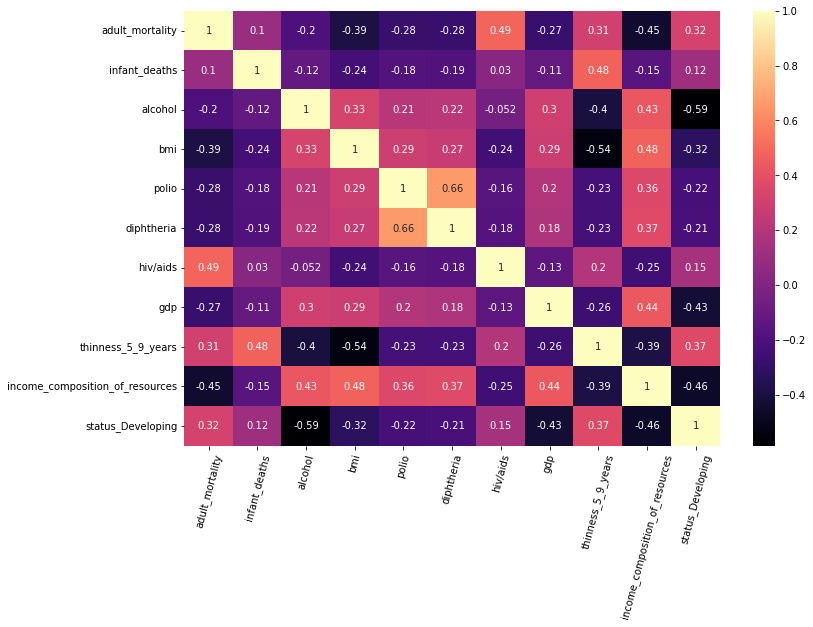

In [ ]:
plt.figure(figsize=(12,8))
g = sns.heatmap(X_train.drop(columns=columns_drop).corr(), cmap='magma', annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

In [ ]:
# Define an Extended Isolation forest model
X_train.drop(columns=columns_drop, inplace=True)
df_X = h2o.H2OFrame(X_train)
df_y = h2o.H2OFrame(y_train)
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = df_X.dim[1] - 1,
                                          seed = 15
                                          )

# Train Extended Isolation Forest
eif.train(x = df_X.columns, 
          training_frame = df_X)

# Calculate score
eif_result = eif.predict(df_X)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [ ]:
evaluate(df_X, df_y, X_test, y_test, estimator='DT', anomaly_score, columns_drop_dt)

In [ ]:
Life_Tree = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=15)
Life_Tree.fit(df_X[anomaly_score <= 0.6].as_data_frame(), df_y[anomaly_score <= 0.6].as_data_frame())
pred = Life_Tree.predict(X_test.drop(columns=columns_drop))
r2_score(y_test, pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9438193385705584